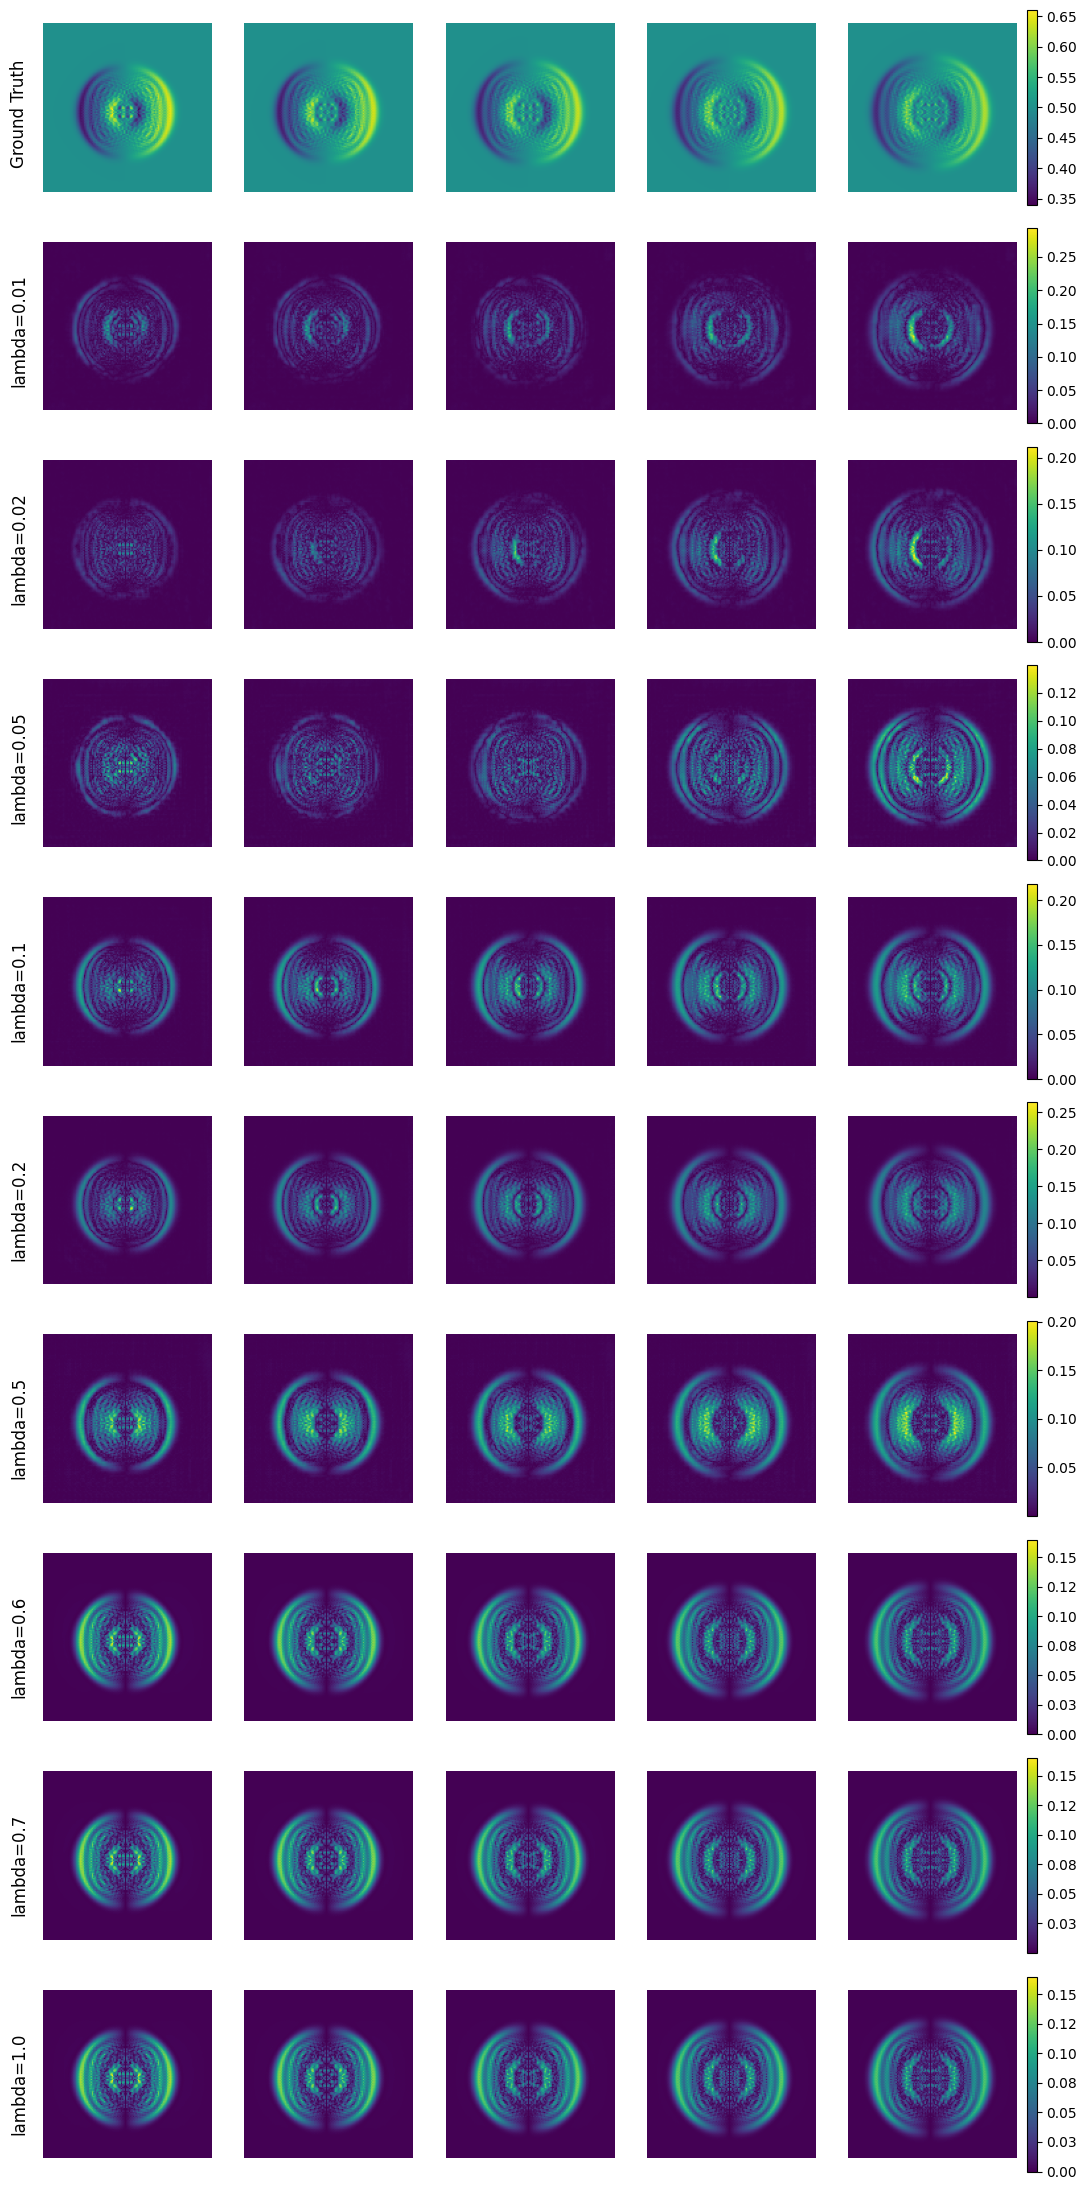

In [5]:
import sys
sys.path.append('/root/autodl-fs/PSTMAE')

from data.dataset import ShallowWaterDataset
from models.timae.pl_model import LitTiMAE
import matplotlib.pyplot as plt
import torch

# dataset
dataset = ShallowWaterDataset(dilation=3)
x, y, mask = dataset[10]
mask = torch.tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1])

# lambdas
lambdas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.6, 0.7, 1.0]

# ground truth
images = y[:, 1]

# prepare figure
rows = 1 + len(lambdas)  # 1 row for GT, rest for errors
cols = 6
fig, axs = plt.subplots(rows, cols, figsize=(11, 2.2*rows),
                        gridspec_kw={'width_ratios': [0, 1, 1, 1, 1, 1.25]})

# Ground Truth row
axs[0, 0].text(x=0, y=0.21, s='Ground Truth', fontsize='large', rotation='vertical')
i_vmin, i_vmax = images.min(), images.max()
for i in range(5):
    im_gt = axs[0, i+1].imshow(images[i], vmin=i_vmin, vmax=i_vmax)
fig.colorbar(im_gt, ax=axs[0, i+1], shrink=1, format='%.2f')

# Loop over lambdas
for row, n in enumerate(lambdas, start=1):
    # load model
    ckpt_path = f'/root/autodl-fs/PSTMAE/logs/timae/lambda_{n}/lightning_logs/version_0/checkpoints/last.ckpt'
    model = LitTiMAE.load_from_checkpoint(ckpt_path, map_location='cpu', dataset=dataset)

    # predict
    pred = model.model(x.unsqueeze(0), mask.unsqueeze(0))[0].squeeze(0).detach()
    reconstructions = pred[10:, 1]

    # error
    diffs = torch.abs(images - reconstructions)

    # label
    axs[row, 0].text(x=0, y=0.21, s=f'lambda={n}', fontsize='large', rotation='vertical')

    # plot errors
    for i in range(5):
        im_err = axs[row, i+1].imshow(diffs[i], vmin=diffs.min(), vmax=diffs.max())
    fig.colorbar(im_err, ax=axs[row, i+1], shrink=1, format='%.2f')

# turn off axes
for i in range(rows):
    for j in range(cols):
        axs[i, j].axis('off')

plt.tight_layout()
# plt.savefig('sw_pred_pstmae_all_lambda.pdf', bbox_inches='tight', dpi=100)
plt.show()